In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io


In [50]:
# load mat file
import scipy.io as sio
#mat_contents = sio.loadmat('data/omer_Pilot_continous_psych_2023-09-26_00h46.01.195.mat')
mat_contents=sio.loadmat('data/092708_continous_psych_2023-10-13_13h45.08.071.mat')
mat_contents.keys()
sigma=mat_contents['sigma']
target=mat_contents['target'] # velocity of target motion for 1200 frames (20 seconds) and 30 trials
response=mat_contents['response'] # velocity of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_x=mat_contents['mouse_x'] # x position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
mouse_y=mat_contents['mouse_y'] # y position of participant's mouse movement for 1200 frames (20 seconds) and 30 trials
blob_x=mat_contents['blob_x'] # x po    sition of target for trialNum200 frames (20 seconds) and 30 trials
blob_y=mat_contents['blob_y'] # y position of target for trialNum200 frames (20 seconds) and 30 trials
# get diff for velocity to find horizontal and vertical velocity
blob_x_velocity=np.diff(blob_x)
blob_y_velocity=np.diff(blob_y)
mouse_x_velocity=np.diff(mouse_x)
mouse_y_velocity=np.diff(mouse_y)
nTrial=len(sigma[0])
nSigma=6
nTrialPerBlock=nTrial//nSigma
nTrialPerSigma=nTrial//nTrialPerBlock
blob_widths=[11,13,17,21,25,29]

In [51]:
sigma
# reshape sigma as a matrix of 6x5 (6 rows and 5 columns)
sigma_matrix=np.reshape(sigma,(nTrial//5,5))

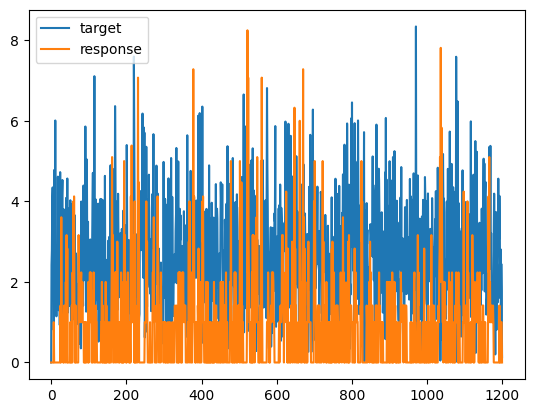

In [30]:
# plot the data
trialNum=0
plt.plot(target[trialNum,:])
plt.plot(response[1,:])
plt.legend(['target','response'])
plt.show()


In [31]:
sigma[0]

array([29, 29, 29, 29, 29, 21, 21, 21, 21, 21, 13, 13, 13, 13, 13, 11, 11,
       11, 11, 11, 25, 25, 25, 25, 25, 17, 17, 17, 17, 17])

In [44]:
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(30):
    trial_dict[i] = {'target': target[i,:], 'response': response[i,:], 'mouse_x': mouse_x[i,:], 'mouse_y': mouse_y[i,:], 'blob_x': blob_x[i,:], 'blob_y': blob_y[i,:], 'sigma': sigma[0][i]}
trial_dict[2]['sigma']


# for each trial remove fitst second(60 Frames) of the data
for i in range(nTrial):
    trial_dict[i]['target']=trial_dict[i]['target'][60:]
    trial_dict[i]['response']=trial_dict[i]['response'][60:]
    trial_dict[i]['mouse_x']=trial_dict[i]['mouse_x'][60:]
    trial_dict[i]['mouse_y']=trial_dict[i]['mouse_y'][60:]
    trial_dict[i]['blob_x']=trial_dict[i]['blob_x'][60:]
    trial_dict[i]['blob_y']=trial_dict[i]['blob_y'][60:]
    #trial_dict[i]['sigma']=trial_dict[i]['sigma'][60:]

In [69]:

# sort the dictionary by sigma
trialDictSorted = sorted(trial_dict.items(), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[3][1]


In [70]:
# dictionary of 5 sigma values and trialNums
sigma_dict={29:0,21:1,13:2,11:3,25:4,17:5}
# redefine sigma_dict using sigma_matrix values
for counter,blob in enumerate(sigma_matrix[:,0]):
    sigma_dict[blob]=counter
sigma_dict

{29: 0, 21: 1, 13: 2, 11: 3, 25: 4, 17: 5}

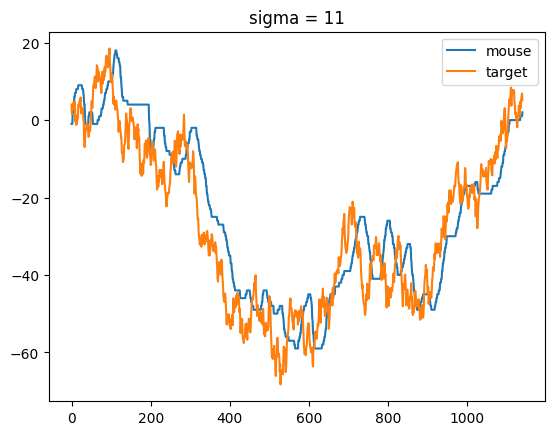

In [71]:
# plot motion trajectory for a single trial
# select trial number from sigma_dict.keys() when sigma is 11
selected_sigma = 11
trialNum= sigma_dict[selected_sigma]*5+0
trialNum=0
X=trialDictSorted[trialNum][1]['mouse_x']
Y=trialDictSorted[trialNum][1]['blob_x']
plt.plot(X)
plt.plot(Y)
plt.legend(['mouse','target'])
plt.title('sigma = '+str(trialDictSorted[trialNum][1]['sigma']))
plt.show()


# Cross Correlogram

In [81]:
len(np.diff(X))


1139

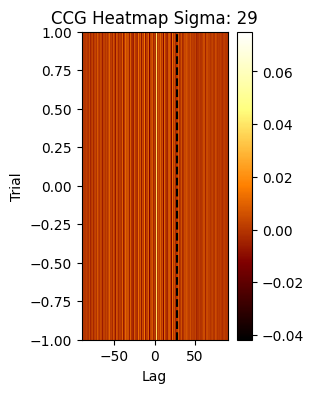

In [84]:
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=29
selected_sigma_ind=sigma_dict[selected_sigma]

tmp_trial=trialDictSorted[selected_sigma_ind*nTrialPerBlock+1][1]

# Normalize the signals
def min_max_normalizer(x):
    return ((x-x.min())/(x.max()-x.min()))*2-1
X=min_max_normalizer(tmp_trial['mouse_x'])
Y=min_max_normalizer(tmp_trial['blob_x'])
ccg=  np.correlate(np.diff(X), np.diff(Y), 'full')
lag_range = 90
mid_point = len(ccg) // 2
ccg_range = ccg[mid_point - lag_range : mid_point+1 + lag_range]
# Create a time vector for the lag range
time_vector = np.arange(-lag_range, lag_range + 1)
# Create heatmap
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.imshow([ccg], cmap='afmhot', aspect='auto', extent=[-lag_range, lag_range, -1, 1])
plt.title('CCG Heatmap Sigma: '+ str(selected_sigma))
plt.xlabel('Lag')
plt.ylabel('Trial')
plt.colorbar()
# Trace peak
peak_index = np.argmax(ccg_range) - lag_range
plt.axvline(peak_index, color='black', linestyle='--')


## Avarage CCG across different blob_widths

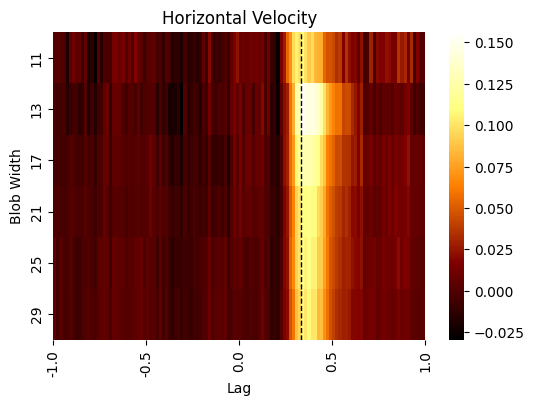

In [89]:
# avarage cross correlation for trials with the same sigma value
blob_widths=[11,13,17,21,25,29]
mean_ccgs=[]
ccg_blob_mean=[]
ccg_single_blob=[]
frameRate=60
lag_time=1 # seconds
lag_range = int(lag_time*frameRate)
len_trial=len(trialDictSorted[0][1]['target'])
mid_trial=int(len_trial/2)
for blob_width in range(len(blob_widths)):
    for i in range(nTrialPerBlock):
        tmp_trial=trialDictSorted[i+blob_width*nTrialPerBlock][1]
        X=tmp_trial['mouse_x']
        Y=tmp_trial['blob_x']
        # normalize X
        X=(X-np.min(X))/(np.max(X)-np.min(X))*2-1
        # normalize Y
        Y=(Y-np.min(Y))/(np.max(Y)-np.min(Y))*2-1
        ccg_single_trial= np.correlate(np.diff(X), np.diff(Y), 'full') 
        #ccg_single_trial = ccg_single_trial[len_trial - lag_range : len_trial + lag_range]
        ccg_single_blob.append(ccg_single_trial)
    ccg_blob_mean.append(np.mean(ccg_single_blob, axis=0))

# Trim ccg_blob_mean to lag_range
ccg_blob_mean=np.array(ccg_blob_mean)
ccg_blob_mean_trimmed = ccg_blob_mean[:, len_trial - lag_range : len_trial + lag_range]
# trim single ccgs
ccg_single_blob=np.array(ccg_single_blob)
ccg_single_blob_trimmed = ccg_single_blob[:, len_trial - lag_range : len_trial + lag_range]

# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_blob_mean_trimmed, cmap='afmhot',yticklabels=blob_widths)

# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
#plt.imshow(ccg_blob_mean, cmap='afmhot', aspect='auto', yticklabels=blob_widths)
plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')

# Find lag indices of peaks in each row
peak_indices = np.argmax(ccg_blob_mean_trimmed, axis=1)
# Trace peak for each blob width
# Add peak lines to the heatmap
for i, peak_index in enumerate(peak_indices):
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/len(blob_widths), ymax=(i+1)/len(blob_widths))
plt.show()
#plt.colorbar()


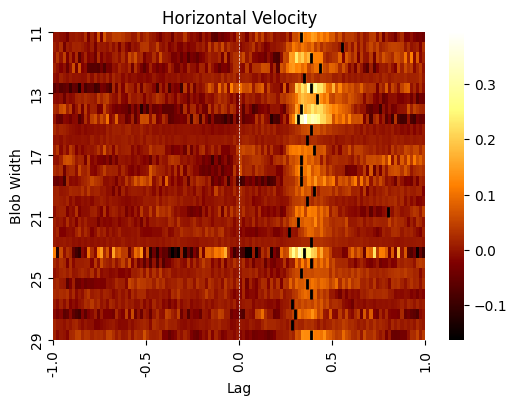

In [90]:
# create heatmap for mean of cross correlation for trials with the same sigma value
plt.figure(figsize=(6, 4))
sns.heatmap(ccg_single_blob_trimmed, cmap='afmhot')
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*lag_time*2, 5)
labels=np.linspace(-lag_time, lag_time, len(x))
plt.xticks(x, labels, rotation='vertical')
## set y axis ticks based on blob widths so that each 5 rows are for the same blob width
yticks=np.linspace(0, len(ccg_single_blob_trimmed), 6)
yticklabels=blob_widths
plt.yticks(yticks, yticklabels)

plt.title('Horizontal Velocity')
plt.xlabel('Lag')
plt.ylabel('Blob Width')
# Find lag indices of peaks in each row
peak_indices = np.argmax(ccg_single_blob_trimmed, axis=1)
# Trace peak for each blob width
# Add peak lines to the heatmap
plt.axvline(x=lag_range,color='white',linestyle='--',linewidth=0.5)

for i, peak_index in enumerate(peak_indices):
    #plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=1, ymin=i/len(blob_widths), ymax=(i+1)/len(blob_widths))
    plt.axvline(x=peak_index, color='black', linestyle='--', linewidth=2, ymin=i/30, ymax=(i+1)/30)
plt.show()


### CCG for single trial

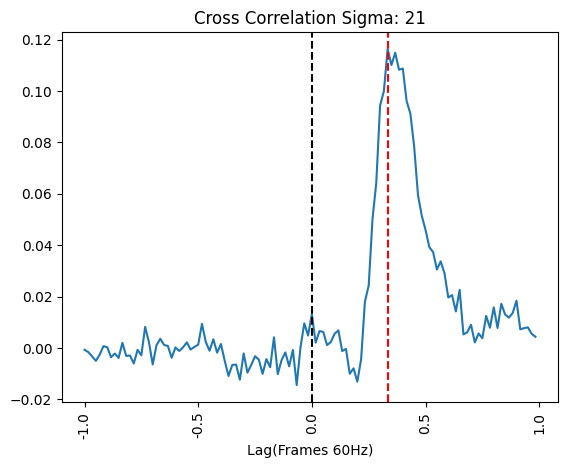

In [93]:
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=21
selected_sigma_ind=sigma_dict[selected_sigma]
# plot corss-correlation for a single trial
len_trial=len(trialDictSorted[0][1]['target'])
frameRate=60
time_lag=1 # seconds
steps=int(frameRate*time_lag)
plt.plot(ccg[len_trial-steps:len_trial+steps])
ccg=ccg_blob_mean[selected_sigma_ind]# set CCG
# set x axis ticks from -120 to 120 with ticks at every 20 units
x=np.linspace(0, frameRate*time_lag*2, 5)
labels=np.linspace(-time_lag, time_lag, len(x))
plt.xticks(x, labels, rotation='vertical')
#plot a vertical line at lag=0
plt.axvline(time_lag*frameRate, color='black', linestyle='--')
# calculate highest correlation
max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
# plot the highest correlation
#plt.axhline(max_corr, color='black', linestyle='--')
plt.axvline(max_corr_index, color='red', linestyle='--')
plt.title('Cross Correlation Sigma: ' + str(trialDictSorted[selected_sigma_ind*5+1][1]['sigma']))
plt.xlabel('Lag(Frames 60Hz)')
plt.show()

## Avarage CCG plots 

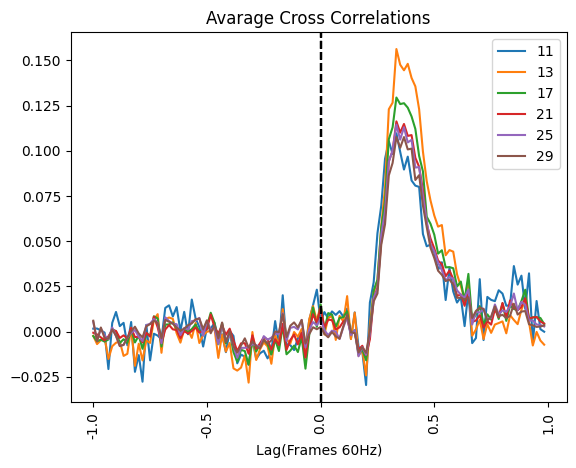

In [95]:
for i,bw in enumerate(blob_widths): 
   # plot corss-correlation for a single trial
    len_trial=len(trialDictSorted[0][1]['target'])
    frameRate=60
    time_lag=1 # seconds
    steps=int(frameRate*time_lag)
    # set CCG
    ccg=ccg_blob_mean[i]
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    # color based on bw
    plt.plot(ccg[len_trial-steps:len_trial+steps], label=bw)
    plt.legend()
    # add bw as a label
    # set x axis ticks from -120 to 120 with ticks at every 20 units
    x=np.linspace(0, frameRate*time_lag*2, 5)
    labels=np.linspace(-time_lag, time_lag, len(x))
    plt.xticks(x, labels, rotation='vertical')
    #plot a vertical line at lag=0
    plt.axvline(time_lag*frameRate, color='black', linestyle='--')
    # calculate highest correlation
    max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
    max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
    plt.title('Avarage Cross Correlations')
    plt.xlabel('Lag(Frames 60Hz)')
    #plt.show()



#### Fig 13: Gaussian fitting of CCG

Text(0, 0.5, 'Cross Correlation')

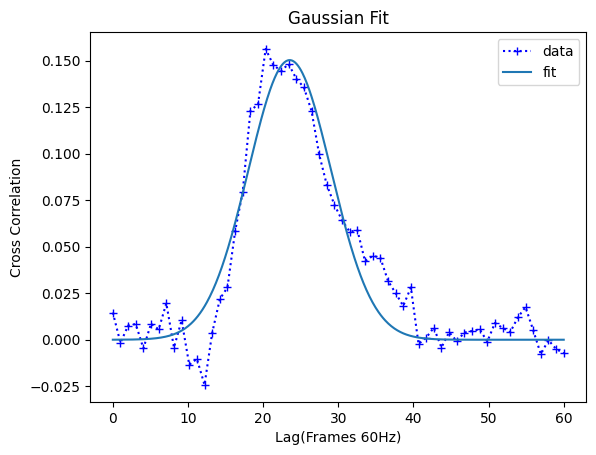

In [195]:
ccg=ccg_blob_mean[1]
len(ccg[len_trial:len_trial+steps])
# fit the ccg data with Gaussian
from scipy.optimize import curve_fit
def gaussian(x, alpha, beta, sigma):
    return alpha*np.exp(-(x-beta)**2/(2*sigma**2))
#xdata = np.linspace(0, 10, 100)
#ydata = gaussian(xdata, 3.5, 5.5, 1.3) + np.random.normal()
xdata=np.linspace(0, steps, steps)
ydata=ccg[len_trial:len_trial+steps]
popt, pcov = curve_fit(gaussian, xdata, ydata)
xFit=np.linspace(0, steps, steps*10)
plt.plot(xdata, ydata, 'b+:', label='data')
plt.plot(xFit, gaussian(xFit, *popt), label='fit')
plt.legend()
plt.title('Gaussian Fit')
plt.xlabel('Lag(Frames 60Hz)')
plt.ylabel('Cross Correlation')


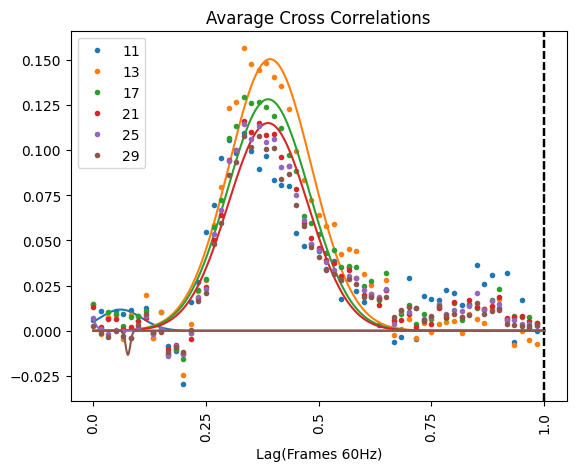

In [193]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
# plot avarage cross correlation for trials with the same sigma value
for i,bw in enumerate(blob_widths): 
# plot corss-correlation for a single trial
   color=np.random.rand(3,)   #random color selector

   len_trial=len(trialDictSorted[0][1]['target'])
   frameRate=60
   time_lag=1 # seconds
   steps=int(frameRate*time_lag)
   # set CCG
   ccg=ccg_blob_mean[i]
   # calculate highest correlation
   max_corr=np.max(ccg[len_trial:len_trial+steps])
   max_corr_index=np.argmax(ccg[len_trial:len_trial+steps])
   # color based on bw
   xdata=np.linspace(0, steps, steps)
   ydata=ccg[len_trial:len_trial+steps]
   plt.plot(ccg[len_trial:len_trial+steps],'o', label=bw, markersize=3, color=colors[i])
   plt.legend()
   # set x axis ticks from 0 to 60 with ticks at every 20 units
   x=np.linspace(0, frameRate*time_lag, 5)
   labels=np.linspace(0, time_lag, len(x))
   plt.xticks(x, labels, rotation='vertical')
   #plot a vertical line at lag=0
   plt.axvline(time_lag*frameRate, color='black', linestyle='--')
   # calculate highest correlation
   max_corr=np.max(ccg[len_trial-steps:len_trial+steps])
   max_corr_index=np.argmax(ccg[len_trial-steps:len_trial+steps])
   plt.title('Avarage Cross Correlations')
   # Gaıssian fit
   xdata=np.linspace(0, steps, steps)
   ydata=ccg[len_trial:len_trial+steps]
   popt, pcov = curve_fit(gaussian, xdata, ydata)
   xFit=np.linspace(0, steps, steps*10)
   plt.plot(xFit, gaussian(xFit, *popt),color=colors[i])


   plt.xlabel('Lag(Frames 60Hz)')
   #plt.show()


## Kalman filter


In [99]:
import numpy as np
from scipy.sparse import diags

def myKalmanFast(x, Q, R):
    """ Kalman filter for position estimates.

    Args:
    x (numpy.ndarray): Target position.
    Q (float): Target displacement variance.
    R (float): Observation noise variance.
    
    Returns:
    xhat (numpy.ndarray): Position estimates.
    y (numpy.ndarray): Noisy sensory observations.
    K (float): Kalman gain.
    P (float): Posterior variance."""
    N = len(x)  # Number of samples
    v = np.random.randn(N) * np.sqrt(R)
    y = x + v  

    P = Q / 2 * (np.sqrt(1 + 4 * R / Q) - 1)  
    K = (P + Q) / (P + Q + R)  
    
    # Create a sparse matrix for D 
    diagonals = [np.ones(N), (K - 1) * np.ones(N)]
    D = diags(diagonals, [0, -1], shape=(N, N)).toarray()
    
    xhat = np.linalg.solve(D, K * y) 
    
    return xhat, y, K, P

In [100]:
# Example implementation
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=11
selected_sigma_ind=sigma_dict[selected_sigma]
tmp_trial=trialDictSorted[selected_sigma_ind*5+1][1]
target_positions_x=tmp_trial['blob_x']
response_positions_x=tmp_trial['mouse_x']

x = target_positions_x  # Replace target_positions with actual target position values
Q = 0.1  # Example target displacement variance
R = 10  # Example observation noise variance
xhat, y, K, P = myKalmanFast(x, Q, R)

# calculate model error
error_xhat=target_positions_x-xhat
# calculate actual error
true_error_x=target_positions_x-response_positions_x

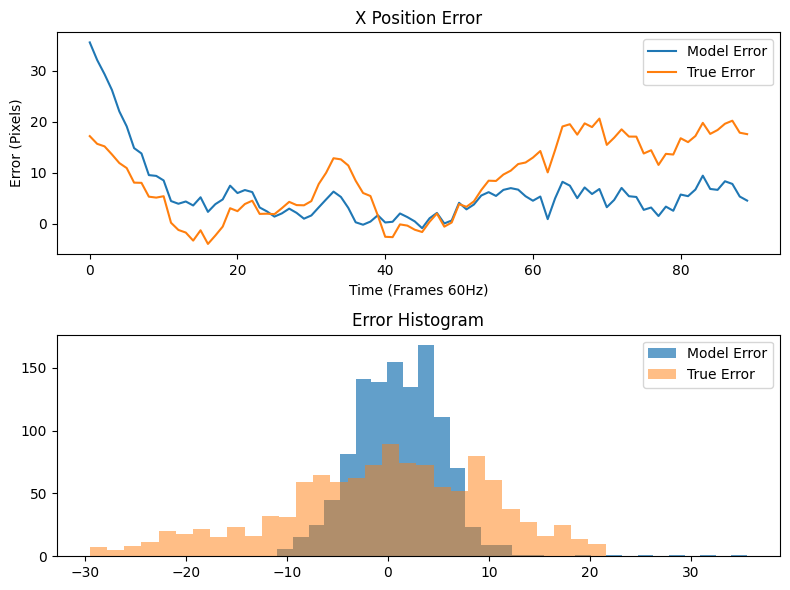

In [102]:
# Plot the position errors
# calculate model error
error_xhat = target_positions_x - xhat
# Plot error for 1.5 seconds
plt.figure(figsize=(8, 6))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[0:90], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[0:90], label='True Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
plt.legend()

# Create a plot to show the proportion of occurrences of each error value
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat, bins=30, alpha=0.7)
plt.hist(true_error_x, bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [103]:
target_positions_x

array([ 39.19252427,  38.67925312,  39.18172753, ..., 115.24788475,
       113.57179027, 113.33314236])

In [105]:
target_positions_x.shape

(1140,)

# Custom Kalman

Filtered Positions: [20.52963455 21.69259042 22.36591162 ... 35.02458439 35.01941231
 34.83584479]


Text(0.5, 1.0, 'Error Histogram')

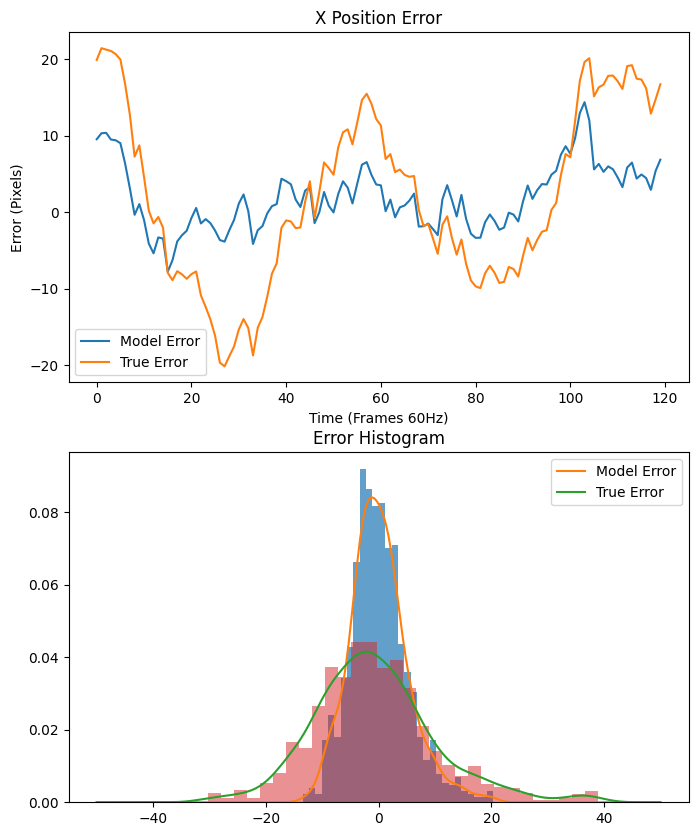

In [107]:
def kalman_filter2(observed_positions, initial_estimate, initial_error, process_variance, measurement_variance):
    """
    Kalman filter implementation for 1D position estimation.

    Parameters:
        observed_positions (list or numpy array): List of observed target positions.
        initial_estimate (float): Initial estimate of the target position.
        initial_error (float): Initial estimation error.
        process_variance (float): Process noise variance (how much the actual position can change over time).
        measurement_variance (float): Measurement noise variance (how noisy the observations are).

    Returns:
        filtered_positions (numpy array): Estimated target positions after applying the Kalman filter.
    """
    # Initialize variables
    estimate = initial_estimate
    error = initial_error

    # Kalman filter loop
    filtered_positions = []
    for observation in observed_positions:
        # Prediction step
        prediction = estimate
        prediction_error = error + process_variance

        # Update step
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        estimate = prediction + kalman_gain * (observation - prediction)
        error = (1 - kalman_gain) * prediction_error

        # Save the filtered estimate
        filtered_positions.append(estimate)

    return np.array(filtered_positions)


# Example implementation
sigma_dict={11:0,13:1,17:2,21:3,25:4,29:5}
selected_sigma=13
selected_sigma_ind=sigma_dict[selected_sigma]
tmp_trial=trialDictSorted[selected_sigma_ind*5+1][1]
# Target information
target_positions_x=tmp_trial['blob_x']
response_positions_x=tmp_trial['mouse_x']
# calculate actual error
true_error_x=target_positions_x-response_positions_x

# Example usage:
observed_positions= target_positions_x
initial_estimate = response_positions_x[0]#10.0  # Initial estimate of the target position
initial_error =true_error_x[0]# 10.0  # Initial estimation error
process_variance = 0.1  # Process noise variance
measurement_variance = 20  # Measurement noise variance
filtered_positions = kalman_filter2(observed_positions, initial_estimate, initial_error, process_variance, measurement_variance)
print("Filtered Positions:", filtered_positions)

# Plot the position errors
# calculate model error
error_xhat = target_positions_x - filtered_positions
# Plot error for 1.5 seconds
plt.figure(figsize=(8, 10))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[60*3:int(60*(3+2))], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[60*3:int((60*(3+2)))], label='True Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
plt.legend()

# plot the histogram of errors
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat, density=True, bins=30, alpha=0.7)
# density of error xhat
from scipy.stats import gaussian_kde
density_xhat = gaussian_kde(error_xhat)
xs = np.linspace(-50, 50, 200)
density_xhat.covariance_factor = lambda : .25
density_xhat._compute_covariance()
plt.plot(xs,density_xhat(xs))
# density of true error
density_true_error = gaussian_kde(true_error_x)
xs = np.linspace(-50, 50, 200)
density_true_error.covariance_factor = lambda : .25
density_true_error._compute_covariance()
plt.plot(xs,density_true_error(xs))
plt.legend(['Model Error', 'True Error'])

plt.hist(true_error_x,density=True, bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')


### Fit data

Text(0.5, 1.0, 'Error Histogram')

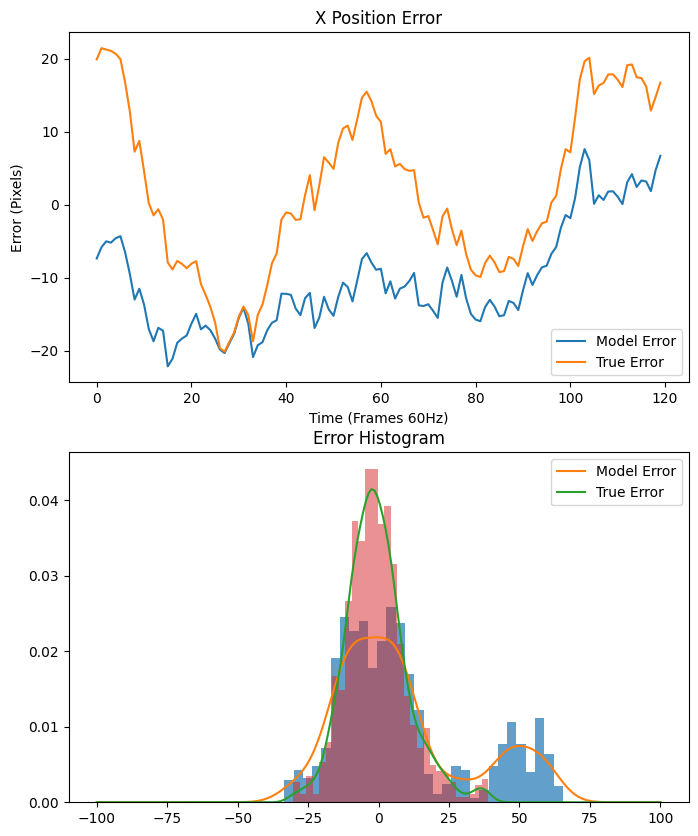

In [108]:
from scipy.optimize import curve_fit
# Initial parameter guesses
initial_estimate_guess = 10.0
initial_error_guess = 1.0
process_variance_guess = 0.1
measurement_variance_guess = 0.5
# Fit the Kalman filter parameters to the observed data
params, covariance = curve_fit(kalman_filter2, np.arange(len(observed_positions)),
                                observed_positions, p0=[initial_estimate_guess, initial_error_guess,
                                                         process_variance_guess, measurement_variance_guess])

# Extract the best-fitting parameters
best_initial_estimate, best_initial_error, best_process_variance, best_measurement_variance = params
# calculate model estimations using the best parameters

filtered_positions=kalman_filter2(observed_positions, best_initial_estimate, best_initial_error, best_process_variance, best_measurement_variance)


# Plot the position errors
# calculate model error
error_xhat = target_positions_x - filtered_positions
# Plot error for 1.5 seconds
plt.figure(figsize=(8, 10
))

# First subplot for model error
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(error_xhat[60*3:int(60*(3+2))], label='Model Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
true_error_x = target_positions_x - response_positions_x
plt.plot(true_error_x[60*3:int((60*(3+2)))], label='True Error')
plt.title('X Position Error')
plt.xlabel('Time (Frames 60Hz)')
plt.ylabel('Error (Pixels)')
plt.legend()

# plot the histogram of errors
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.hist(error_xhat, bins=30,density=True, alpha=0.7)
# density of error xhat
from scipy.stats import gaussian_kde
density_xhat = gaussian_kde(error_xhat)
xs = np.linspace(-100, 100, 200)
density_xhat.covariance_factor = lambda : .25
density_xhat._compute_covariance()
plt.plot(xs,density_xhat(xs))
# density of true error
density_true_error = gaussian_kde(true_error_x)
xs = np.linspace(-100, 100, 200)
density_true_error.covariance_factor = lambda : .25
density_true_error._compute_covariance()
plt.plot(xs,density_true_error(xs))
plt.legend(['Model Error', 'True Error'])

plt.hist(true_error_x,density=True, bins=30,alpha=0.5)
plt.legend(['Model Error', 'True Error'])
plt.title('Error Histogram')


#

# Uncertainity estimates

In [ ]:
blob_widths

[11, 13, 17, 21, 25, 29]